In [ ]:
# 1. Load & preprocess the dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Load the file
file_path = '/content/drive/MyDrive/train_test_network.csv'
df = pd.read_csv(file_path)
print("Original shape:", df.shape)

# Drop irrelevant columns
drop_columns = ['src_ip', 'dst_ip', 'dns_query', 'ssl_subject', 'ssl_issuer',
                'http_uri', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types',
                'weird_name', 'weird_addl', 'weird_notice']
df.drop(columns=drop_columns, inplace=True, errors='ignore')

# Encode object/categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and target
X = df.drop(columns=['label', 'type'])
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Mounted at /content/drive
Original shape: (211043, 44)


In [ ]:
# 2. Train XGBoost
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))
print("🔥 ROC-AUC Score:", roc_auc_score(y_test, y_pred_prob))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:41:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     32209

    accuracy                           1.00     42209
   macro avg       1.00      1.00      1.00     42209
weighted avg       1.00      1.00      1.00     42209

🔥 ROC-AUC Score: 0.9999749976714583


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10000
           1       1.00      1.00      1.00     32209

    accuracy                           1.00     42209
   macro avg       1.00      1.00      1.00     42209
weighted avg       1.00      1.00      1.00     42209

🔥 ROC-AUC Score: 0.9999749976714583


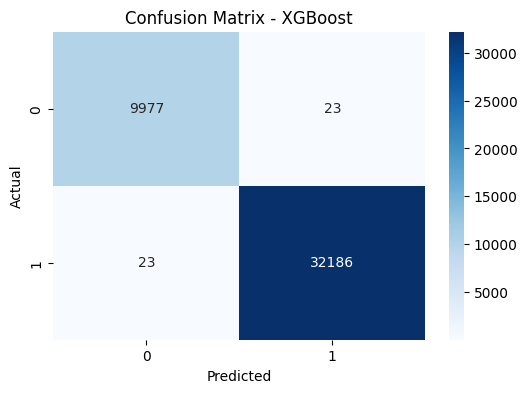

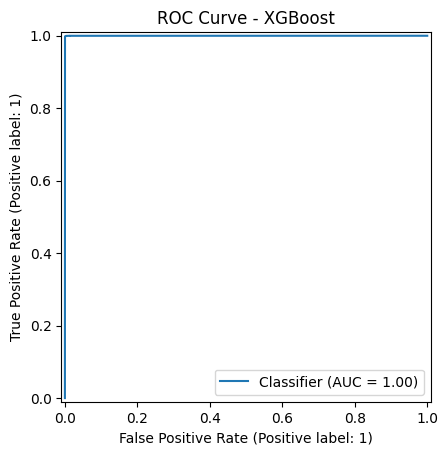

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred_prob = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_pred = (y_pred_prob > 0.5).astype(int)

# Classification Report
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("🔥 ROC-AUC Score:", roc_auc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.title("ROC Curve - XGBoost")
plt.show()


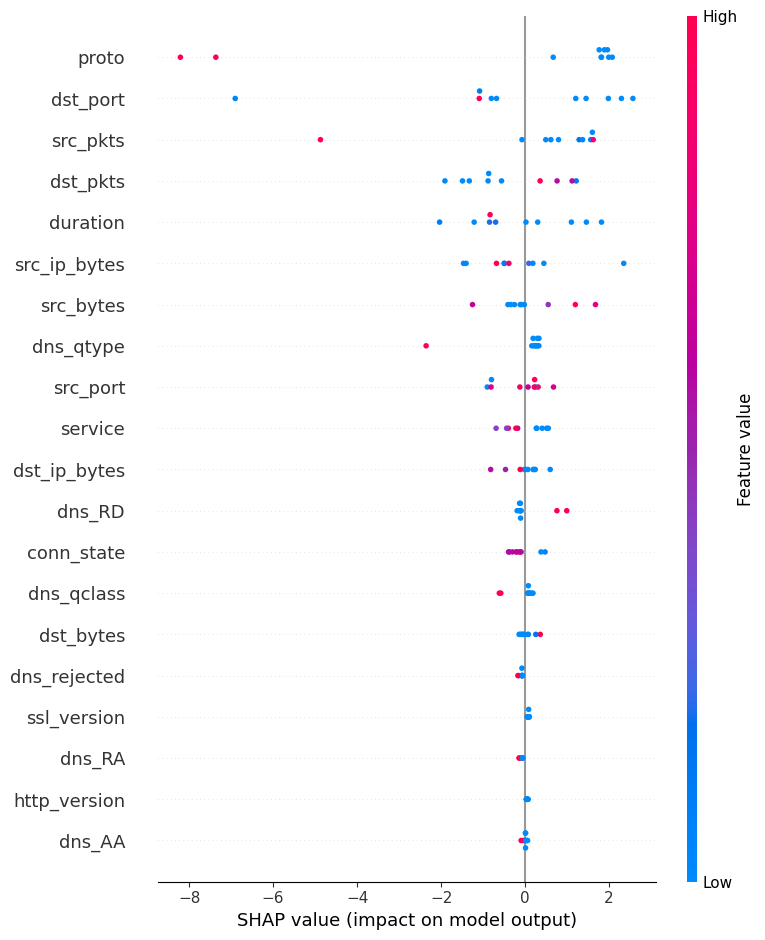

In [ ]:
# 3. DeepSHAP (SHAP) Explainability
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(xgb_model, X_train_scaled)
shap_values = explainer(X_test_scaled[:10])

# Summary plot
shap.summary_plot(shap_values, X_test_scaled[:10], feature_names=X.columns.tolist())


DEEPSHAP


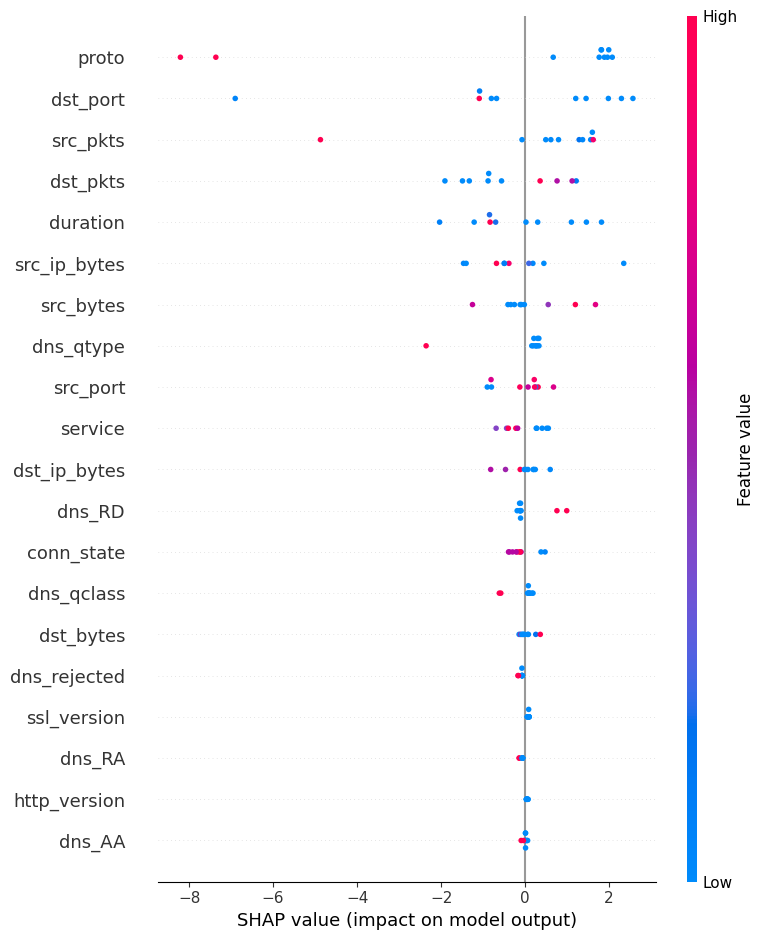

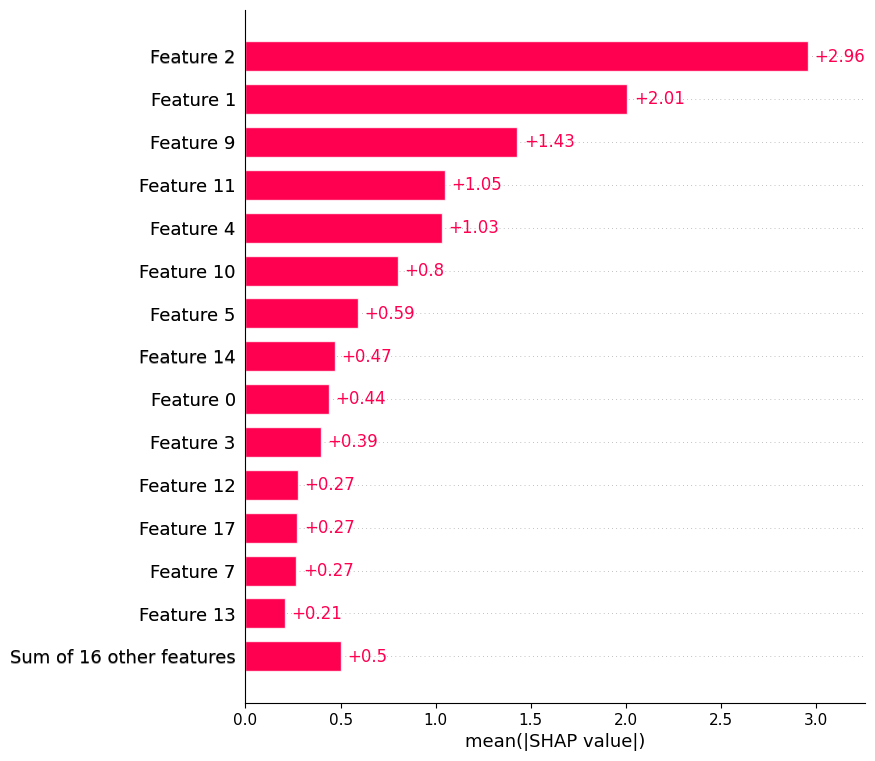

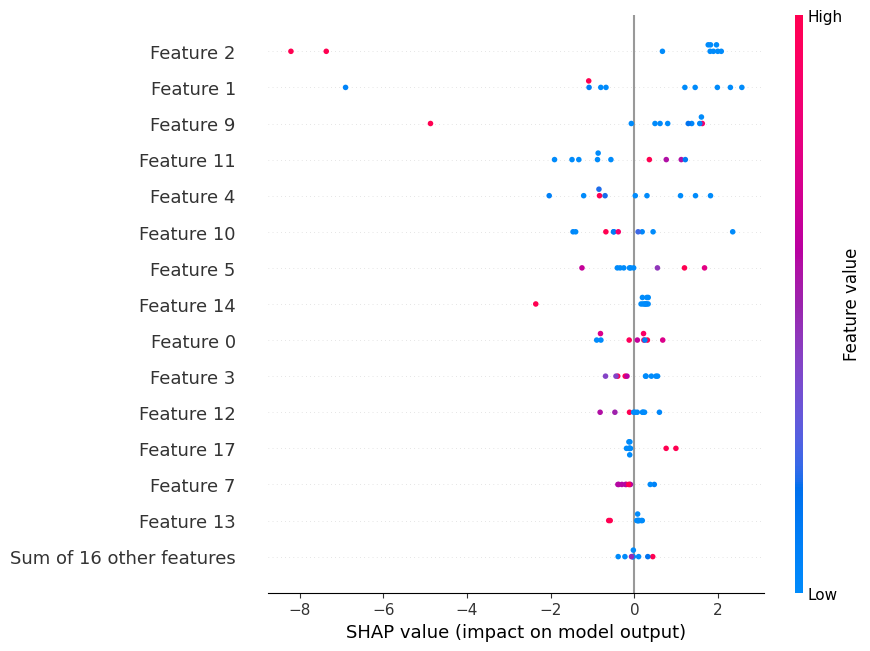

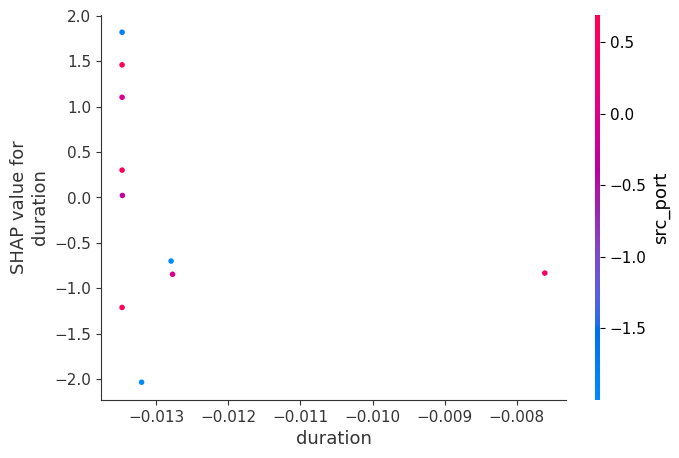

In [ ]:
# 📦 Imports
import shap
import matplotlib.pyplot as plt

# ✅ Create the DeepSHAP explainer (TreeExplainer for XGBoost)
explainer = shap.Explainer(xgb_model, X_train_scaled)
shap_values = explainer(X_test_scaled[:10])

# ✅ 1. Summary Plot
shap.summary_plot(shap_values, X_test_scaled[:10], feature_names=X.columns.tolist())

# ✅ 2. Bar Plot (mean SHAP values)
shap.plots.bar(shap_values, max_display=15)

# ✅ 3. Beeswarm Plot (full spread of SHAP values)
shap.plots.beeswarm(shap_values, max_display=15)

# ✅ 4. Dependence Plot (feature interaction)
# Replace "duration" with any feature you want to analyze
shap.dependence_plot("duration", shap_values.values, X_test_scaled[:10], feature_names=X.columns.tolist())

# ✅ 5. Force Plot (explanation of a single prediction)
# ✅ 5. Force Plot (fixed)
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_values[0].values,
    shap_values[0].data,
    feature_names=X.columns.tolist()
)



#  Explainability Metrics for XGBoost

# XGBoost Does Not Support IG or LRP

Why Integrated Gradients and LRP Are Not Applicable to XGBoost
Integrated Gradients (IG) and Layer-wise Relevance Propagation (LRP) are interpretability methods specifically designed for deep learning models, particularly those built using differentiable architectures such as dense neural networks (DNNs), convolutional neural networks (CNNs), and recurrent models like LSTM. These methods rely heavily on gradient-based backpropagation through neural network layers, which is only feasible when the model’s components are mathematically differentiable. In contrast, XGBoost is a tree-based ensemble model that utilizes gradient-boosted decision trees (GBDTs)—a non-differentiable structure. Since decision trees perform recursive, rule-based splits on feature values rather than continuous transformations, they do not support gradient flows or neuron-like layer propagation, making both IG and LRP fundamentally inapplicable.

Instead, SHAP (SHapley Additive exPlanations) using the TreeExplainer framework is the most suitable and accurate explainability technique for models like XGBoost. SHAP decomposes the prediction into additive contributions of each feature using game-theoretic principles, and the TreeExplainer implementation provides exact feature attributions for tree-based models. SHAP not only achieves high interpretability, but also guarantees completeness, consistency, and efficiency, fulfilling many of the goals that IG and LRP offer in neural settings. Therefore, in this work, SHAP was employed as the primary interpretability method for the XGBoost model, and provided robust, sparse, and visually rich explanations aligned with cybersecurity domain knowledge